## Importing the required libiraries

In [1]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

## Importing the dataset

In [4]:
df = pd.read_csv(
    "SMSSpamCollection.csv",
    sep="\t",
    header=None,
    names=["label", "message"],
    encoding="utf-8"
)

In [5]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


## Data Exploration

#### Class Distribution

In [6]:
df['label'].value_counts().unique()

array([4825,  747])

In [7]:
df['label'].value_counts(normalize=True) * 100

label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64

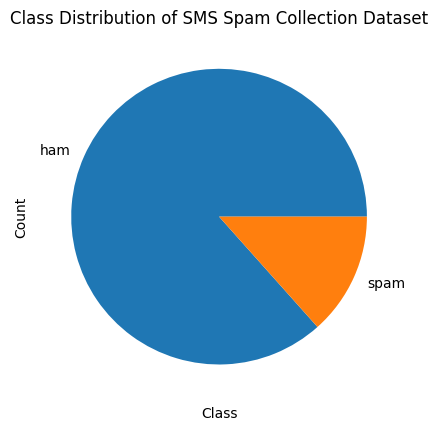

In [8]:
df['label'].value_counts().plot(kind='pie')
plt.title("Class Distribution of SMS Spam Collection Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Message length based on Labels

In [9]:
df['message_length'] = df['message'].apply(len)

df.groupby('label')['message_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


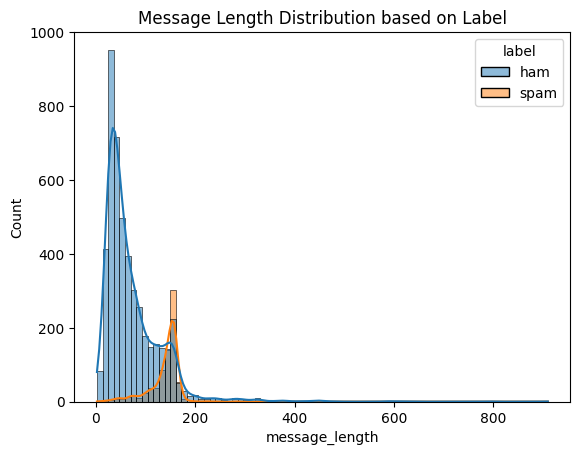

In [10]:
sns.histplot(data=df, x='message_length', hue='label', bins=80, kde=True)
plt.title("Message Length Distribution based on Label")
plt.show()

#### Word Counts Based on Labels

In [11]:
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

df.groupby('label')['word_count'].mean()

label
ham     14.310259
spam    23.911647
Name: word_count, dtype: float64

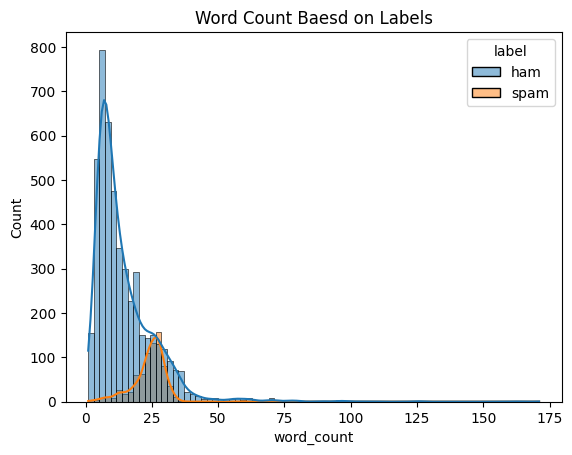

In [12]:
sns.histplot(data=df, x='word_count', hue='label', bins=80, kde=True)

plt.title("Word Count Baesd on Labels")
plt.show()

In [13]:
from collections import Counter
spam_words = Counter(" ".join(df[df['label']=='spam']['message']).split()).most_common(10)
ham_words = Counter(" ".join(df[df['label']=='ham']['message']).split()).most_common(10)

print("most common words in spam messages: ", spam_words)
print ("most common words in ham messages: ", ham_words)

most common words in spam messages:  [('to', 607), ('a', 360), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]
most common words in ham messages:  [('to', 1538), ('you', 1462), ('I', 1439), ('the', 1029), ('a', 977), ('i', 742), ('and', 739), ('in', 736), ('u', 651), ('is', 645)]


### Word Cloud

In [14]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df['clean_message'] = df['message'].apply(clean_text)

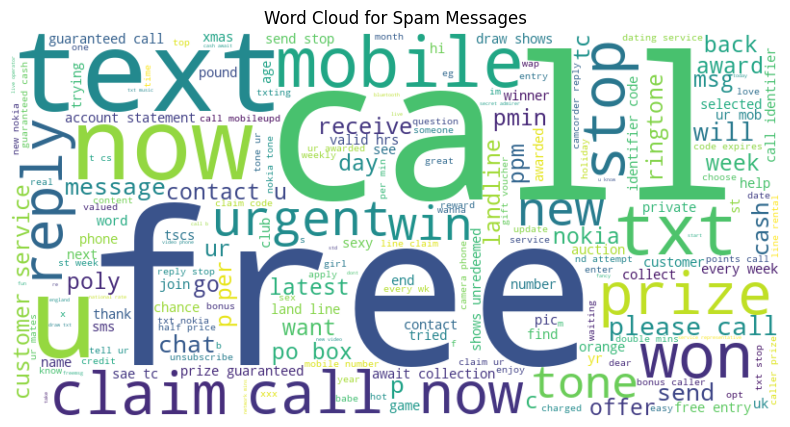

In [15]:
ham_text = " ".join(df[df['label'] == 'spam']['clean_message'])

ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Spam Messages")
plt.show()

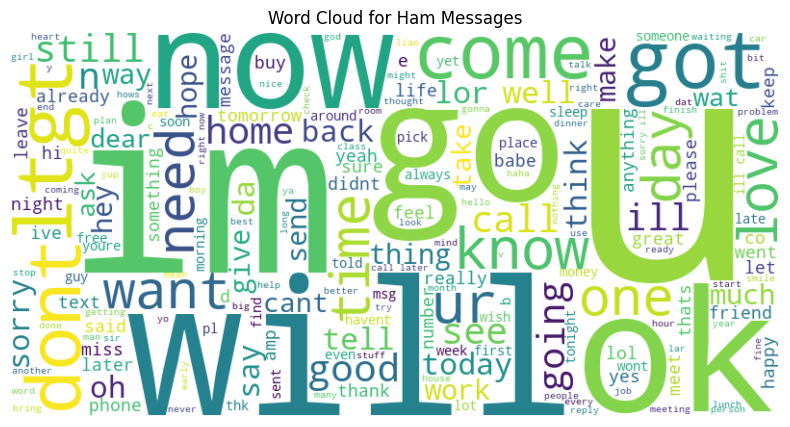

In [16]:
ham_text = " ".join(df[df['label'] == 'ham']['clean_message'])

ham_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Ham Messages")
plt.show()

### Text Preprocessing

#### Downloading requied nltk 

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return " ".join(tokens)

df['processed_message'] = df['message'].apply(preprocess)
df['processed_message']

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts may...
3                     u dun say early hor u c already say
4                     nah think go usf life around though
                              ...                        
5567    time tried contact u pound prize claim easy ca...
5568                          ü b going esplanade fr home
5569                                 pity mood suggestion
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: processed_message, Length: 5572, dtype: object

### Feature Extraction

In [19]:
vectorizer = TfidfVectorizer(max_features=3000)

X = vectorizer.fit_transform(df['processed_message'])
y = df['label'].map({'ham': 0, 'spam': 1})

In [20]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 38677 stored elements and shape (5572, 3000)>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Model Training

In [24]:
class LinearSVM:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=1000):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        y_ = np.where(y == 1, 1, -1)

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def decision_function(self, X):
        return np.dot(X, self.w) + self.b

In [25]:
linear_svm = LinearSVM()
linear_svm.fit(X_train.toarray(), y_train.values)
linear_svm_preds = linear_svm.predict(X_test.toarray())
linear_svm_preds = np.where(linear_svm_preds == -1, 0, 1)

#### SVM Model Evaluation

In [26]:
print(classification_report(y_test, linear_svm_preds))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

#### SVM Improvised

In [27]:
class ClassWeightedSVM:
    """SVM with class weights to handle imbalanced data"""
    
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000, class_weight='balanced'):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.class_weight = class_weight
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        # Convert sparse matrix to dense if needed
        if hasattr(X, 'toarray'):
            X = X.toarray()
        
        n_samples, n_features = X.shape
        
        # Compute class weights
        unique, counts = np.unique(y, return_counts=True)
        if self.class_weight == 'balanced':
            # Formula: n_samples / (n_classes * class_count)
            weights = {cls: n_samples / (len(unique) * count) for cls, count in zip(unique, counts)}
        else:
            weights = {cls: 1.0 for cls in unique}
        
        # Create sample weights array
        sample_weights = np.array([weights[label] for label in y])
        
        print(f"Class weights: {weights}")
        print(f"Spam weight is {weights[1]/weights[0]:.2f}x larger than Ham weight")
        
        # Initialize parameters
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Convert labels to -1 and 1
        y_ = np.where(y <= 0, -1, 1)
        
        # Training loop with weighted updates
        for iteration in range(self.n_iters):
            for idx in range(n_samples):
                x_i = X[idx]
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                
                # Get weight for this sample
                weight = sample_weights[idx]
                
                if condition:
                    # Correctly classified
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # Misclassified - apply class weight
                    self.w -= self.lr * (2 * self.lambda_param * self.w - weight * x_i * y_[idx])
                    self.b -= self.lr * weight * y_[idx]
    
    def decision_function(self, X):
        # Convert sparse matrix to dense if needed
        if hasattr(X, 'toarray'):
            X = X.toarray()
        return np.dot(X, self.w) - self.b
    
    def predict(self, X):
        # Convert sparse matrix to dense if needed
        if hasattr(X, 'toarray'):
            X = X.toarray()
        output = np.dot(X, self.w) - self.b
        predictions = np.sign(output)
        # Convert back to 0 and 1
        return np.where(predictions <= 0, 0, 1)

    def predict_proba(self, X):
        """
        Predict probability scores using sigmoid transformation
        Returns: array of shape (n_samples, 2) with [prob_ham, prob_spam]
        """
        decision_scores = self.decision_function(X)
        # Apply sigmoid to convert to probabilities
        prob_spam = 1 / (1 + np.exp(-decision_scores))
        prob_ham = 1 - prob_spam
        return np.column_stack([prob_ham, prob_spam])

#### Implementing the SVM Model

In [28]:
svm_weighted = ClassWeightedSVM(
    learning_rate=0.0001,
    lambda_param=0.01,
    n_iters=1000,
    class_weight='balanced'
)
svm_weighted.fit(X_train, y_train)

# Predictions
y_pred_weighted = svm_weighted.predict(X_test)

svm_scores = svm_weighted.decision_function(X_test)

svm_probs = svm_weighted.predict_proba(X_test)
svm_spam_probs = svm_probs[:, 1]


Class weights: {np.int64(0): np.float64(0.577481212749417), np.int64(1): np.float64(3.7265886287625416)}
Spam weight is 6.45x larger than Ham weight


In [29]:
print(classification_report(y_test, y_pred_weighted, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.95      0.99      0.97       966
        Spam       0.94      0.67      0.78       149

    accuracy                           0.95      1115
   macro avg       0.95      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115



#### Visualization of SVM Evaluation

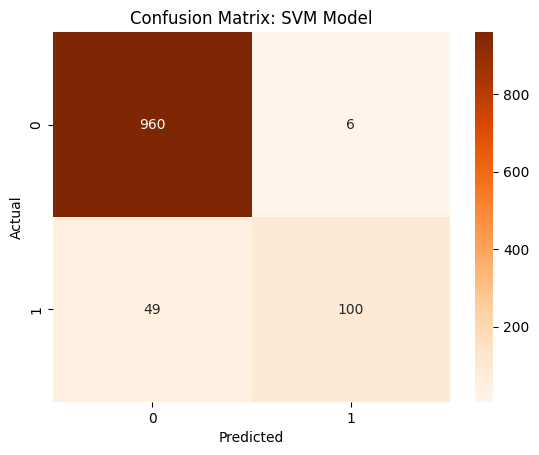

In [31]:
svm_cm = confusion_matrix(y_test, y_pred_weighted)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: SVM Model")
plt.show()

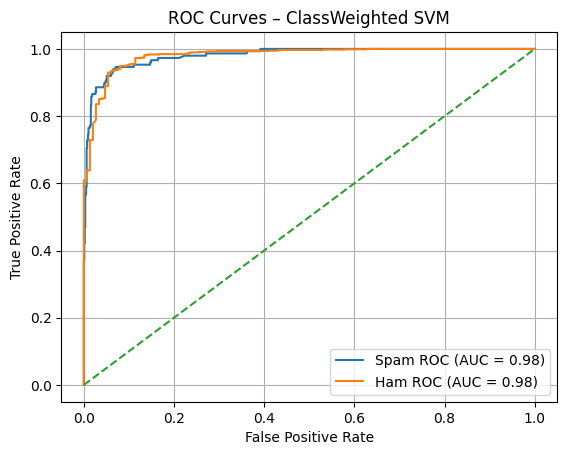

In [41]:
fpr_spam, tpr_spam, _ = roc_curve(y_test, svm_scores, pos_label=1)
roc_auc_spam = auc(fpr_spam, tpr_spam)

fpr_ham, tpr_ham, _ = roc_curve(1 - y_test, -svm_scores, pos_label=1)
roc_auc_ham = auc(fpr_ham, tpr_ham)

plt.figure()
plt.plot(fpr_spam, tpr_spam, label=f"Spam ROC (AUC = {roc_auc_spam:.2f})")
plt.plot(fpr_ham, tpr_ham, label=f"Ham ROC (AUC = {roc_auc_ham:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – ClassWeighted SVM")
plt.legend()
plt.grid()
plt.show()

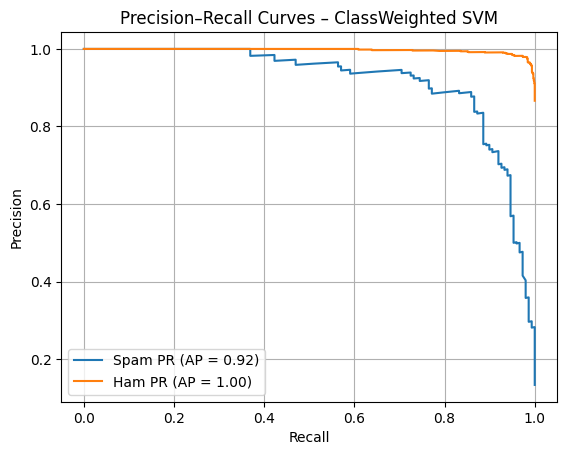

In [40]:
precision_spam, recall_spam, _ = precision_recall_curve(y_test, svm_scores)
ap_spam = average_precision_score(y_test, svm_scores)

precision_ham, recall_ham, _ = precision_recall_curve(1 - y_test, -svm_scores)
ap_ham = average_precision_score(1 - y_test, -svm_scores)

plt.figure()
plt.plot(recall_spam, precision_spam, label=f"Spam PR (AP = {ap_spam:.2f})")
plt.plot(recall_ham, precision_ham, label=f"Ham PR (AP = {ap_ham:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – ClassWeighted SVM")
plt.legend()
plt.grid()
plt.show()

### Ensemble Learning

#### Logistic Regression

In [43]:
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    C=1.0,
    solver='liblinear'
)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

#### Naive Bayes

In [44]:
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)

#### Combining Model results

In [45]:
lr_prob = lr.predict_proba(X_test)[:,1]
nb_prob = nb.predict_proba(X_test)[:,1]

final_prob = (0.6 * lr_prob) + (0.4 * nb_prob)
ensemble_preds = (final_prob >= 0.5).astype(int)

#### Model Evaluations

In [46]:
print("Logistic Regression")
print(classification_report(y_test, lr_preds))

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.92      0.92       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [47]:
print("Naive Bayes")
print(classification_report(y_test, nb_preds))

Naive Bayes
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.98      0.82      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [48]:
print("Ensemble Model")
print(classification_report(y_test, ensemble_preds))

Ensemble Model
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



#### Model result Visualization

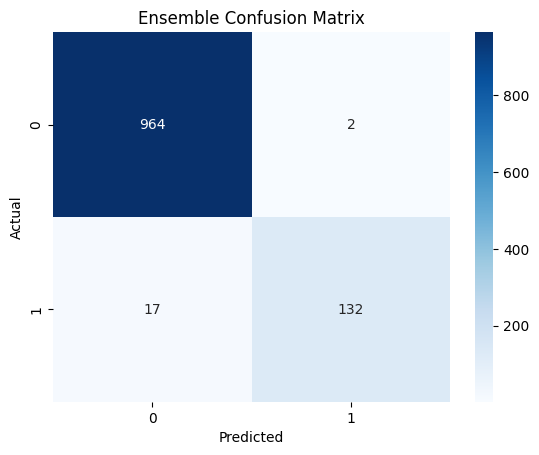

In [49]:
sns.heatmap(confusion_matrix(y_test, ensemble_preds),
            annot=True, fmt='d', cmap='Blues')
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

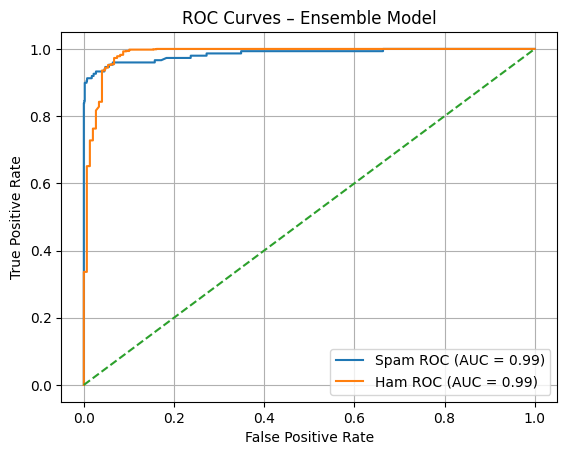

In [71]:
y_true = y_test

fpr_spam, tpr_spam, _ = roc_curve(y_true, final_prob, pos_label=1)
roc_auc_spam = auc(fpr_spam, tpr_spam)

fpr_ham, tpr_ham, _ = roc_curve(1 - y_true, 1 - final_prob, pos_label=1)
roc_auc_ham = auc(fpr_ham, tpr_ham)

plt.figure()
plt.plot(fpr_spam, tpr_spam, label=f"Spam ROC (AUC = {roc_auc_spam:.2f})")
plt.plot(fpr_ham, tpr_ham, label=f"Ham ROC (AUC = {roc_auc_ham:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Ensemble Model")
plt.legend()
plt.grid()
plt.show()

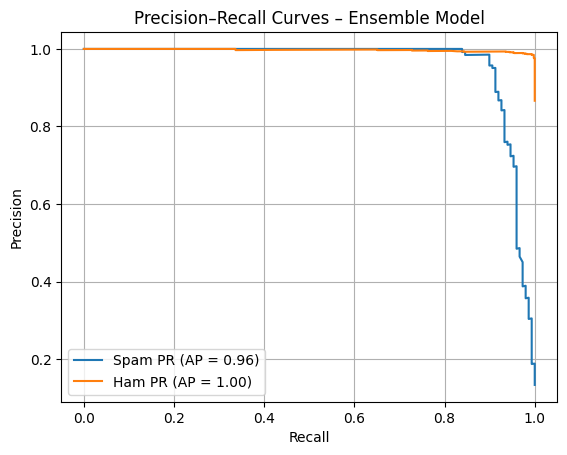

In [53]:
precision_spam, recall_spam, _ = precision_recall_curve(y_true, final_prob)
ap_spam = average_precision_score(y_true, final_prob)

precision_ham, recall_ham, _ = precision_recall_curve(1 - y_true, 1 - final_prob)
ap_ham = average_precision_score(1 - y_true, 1 - final_prob)

plt.figure()
plt.plot(recall_spam, precision_spam, label=f"Spam PR (AP = {ap_spam:.2f})")
plt.plot(recall_ham, precision_ham, label=f"Ham PR (AP = {ap_ham:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves – Ensemble Model")
plt.legend()
plt.grid()
plt.show()

### Model in Action

In [68]:
sample_messages = [
    "Congratulations! You have won a free ticket. Call now!",
    "Hey, are we still meeting for lunch today?",
    "URGENT! Claim your cash prize by sending your bank details",
    "Can you send me the notes from yesterday's class?",
    "You have been selected for a limited time offer"
]

#pre-processing step
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

processed_samples = [preprocess_text(msg) for msg in sample_messages]

#tf-idf
X_samples = vectorizer.transform(processed_samples)

X_samples_dense = X_samples.toarray()

#svm
svm_scores = svm_weighted.decision_function(X_samples_dense)
svm_preds = (svm_scores >= 0).astype(int)

#logistic regression
lr_preds = lr.predict(X_samples)
lr_probs = lr.predict_proba(X_samples)[:, 1]

# naive bayes
nb_preds = nb.predict(X_samples)
nb_probs = nb.predict_proba(X_samples)[:, 1]

# Ensemble model
w_lr = 0.6
w_nb = 0.4

ensemble_probs = (w_lr * lr_probs) + (w_nb * nb_probs)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

In [69]:
results_df = pd.DataFrame({
    "Message": sample_messages,
    "SVM Prediction": ["Spam" if p == 1 else "Ham" for p in svm_preds],
    "SVM Score": svm_scores.round(2),
    "LR Prediction": ["Spam" if p == 1 else "Ham" for p in lr_preds],
    "NB Prediction": ["Spam" if p == 1 else "Ham" for p in nb_preds],
    "Ensemble Prediction": ["Spam" if p == 1 else "Ham" for p in ensemble_preds],
    "Ensemble Probability": ensemble_probs.round(2)
})

results_df

,Message,SVM Prediction,SVM Score,LR Prediction,NB Prediction,Ensemble Prediction,Ensemble Probability
0,Congratulations! You have won a free ticket. C...,Spam,0.54,Spam,Ham,Spam,0.62
1,"Hey, are we still meeting for lunch today?",Ham,-0.83,Ham,Ham,Ham,0.02
2,URGENT! Claim your cash prize by sending your ...,Spam,0.41,Spam,Spam,Spam,0.96
3,Can you send me the notes from yesterday's class?,Ham,-0.53,Ham,Ham,Ham,0.15
4,You have been selected for a limited time offer,Ham,-0.34,Ham,Spam,Spam,0.51
